In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
#import ogb
import ast
pd.set_option('display.max_rows', 100)
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from sklearn.preprocessing import StandardScaler

cwd = os.getcwd()
print(cwd)
cwd_parent = os.path.abspath(os.path.join(cwd, os.pardir))
# cwd_parent = os.path.abspath(os.path.join(cwd, '../../'))
print(cwd_parent)

sys.path.append(cwd_parent)

import deepadr
from deepadr.dataset import *
from deepadr.utilities import *
from deepadr.chemfeatures import *
from deepadr.train_functions_flat import *
from deepadr.model_gnn_ogb import GNN, DeepAdr_SiameseTrf, ExpressionNN



/home/ubuntu/mnt/graphnn/notebooks
/home/ubuntu/mnt/graphnn


In [2]:
rawdata_dir = '../data/raw/'
processed_dir = '../data/processed/'
up_dir = '..'
report_available_cuda_devices()
n_gpu = torch.cuda.device_count()
n_gpu
print("torch:", torch.__version__)
print("CUDA:", torch.version.cuda)
fdtype = torch.float32

number of GPUs available: 1
cuda:0, name:Tesla T4
total memory available: 14.755615234375 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

torch: 2.0.0+cu117
CUDA: 11.7


/home/ubuntu/anaconda3/envs/bedict_crispr/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


### Preparing dataset 

In [4]:
# options: 
# 'total_thresh' + 4,3,2
# 'loewe_thresh', 'hsa_thresh', 'bliss_thresh', 'zip_thresh' + 1
score = 'zip_thresh'
score_val = 1
DSdataset_name = f'DrugComb_{score}_{score_val}'
data_fname = 'data_v1' # v2 for baseline models, v3 for additive samples, v4 for additive baseline

In [5]:
df_drugcomb = pd.read_csv(f'../data/preprocessing/drugcomb_{score}_{score_val}.csv')
df_drugcomb

,Drug1_ID,Drug2_ID,Cell_Line_ID,Cosmic_ID,Drug1,Drug2,Y
0,dacarbazine,717906-29-1,A-673,684052,CN(C)N=NC1=C(NC=N1)C(=O)N,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
1,CHEMBL3348974,717906-29-1,A-673,684052,CC(C)OC(=O)C(C)NP(=O)(OCC1C(C(C(O1)N2C=CC(=O)N...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,1
2,Nesbuvir,717906-29-1,A-673,684052,CNC(=O)C1=C(OC2=CC(=C(C=C21)C3CC3)N(CCO)S(=O)(...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
3,BMS-599626,717906-29-1,A-673,684052,CC1=C2C(=NC=NN2C=C1NC(=O)OCC3COCCN3)NC4=CC5=C(...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,1
4,WZ8040,717906-29-1,A-673,684052,CN1CCN(CC1)C2=CC=C(C=C2)NC3=NC=C(C(=N3)SC4=CC=...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,1
...,...,...,...,...,...,...,...
89076,Vorinostat,KU-60019,VM-CUB-1,909780,C1=CC=C(C=C1)NC(=O)CCCCCCC(=O)NO,CC1CN(CC(O1)C)CC(=O)NC2=CC3=C(C=C2)SC4=C(C=CC=...,1
89077,AZD5582,AZD4320,VM-CUB-1,909780,CC(C(=O)NC(C1CCCCC1)C(=O)N2CCCC2C(=O)NC3C(CC4=...,CN(CCC(CSC1=CC=CC=C1)NC2=C(C=C(C=C2)S(=O)(=O)N...,0
89078,957054-30-7,Sapitinib,VM-CUB-1,909780,CS(=O)(=O)N1CCN(CC1)CC2=CC3=C(S2)C(=NC(=N3)C4=...,CNC(=O)CN1CCC(CC1)OC2=C(C=C3C(=C2)C(=NC=N3)NC4...,1
89079,957054-30-7,Selumetinib,VM-CUB-1,909780,CS(=O)(=O)N1CCN(CC1)CC2=CC3=C(S2)C(=NC(=N3)C4=...,CN1C=NC2=C1C=C(C(=C2F)NC3=C(C=C(C=C3)Br)Cl)C(=...,1


In [6]:
len(df_drugcomb['Drug1'].unique())

1708

In [7]:
len(df_drugcomb['Drug2'].unique())

321

In [8]:
len(set(df_drugcomb['Drug1'].unique()) | set(df_drugcomb['Drug2'].unique()))


1734

In [9]:
df_rma_landm = pd.read_csv('../data/preprocessing/df_rma_landm.tsv', sep="\t")
df_rma_landm

,Unnamed: 0,GENE_SYMBOLS,GENE_title,DATA.906826,DATA.687983,DATA.910927,DATA.1240138,DATA.1240139,DATA.906792,DATA.910688,...,DATA.753584,DATA.907044,DATA.998184,DATA.908145,DATA.1659787,DATA.1298157,DATA.1480372,DATA.1298533,DATA.930299,DATA.905954.1
0,0,TSPAN6,tetraspanin 6 [Source:HGNC Symbol;Acc:11858],7.632023,7.548671,8.712338,7.797142,7.729268,7.074533,3.285198,...,7.105637,3.236503,3.038892,8.373223,6.932178,8.441628,8.422922,8.089255,3.112333,7.153127
1,3,SCYL3,SCY1-like 3 (S. cerevisiae) [Source:HGNC Symbo...,3.614794,4.066887,3.956230,4.063701,4.341500,4.270903,5.968168,...,3.696835,4.624013,4.348524,3.858121,3.947561,4.425849,3.550390,4.443337,4.266828,4.100493
2,19,BAD,BCL2-associated agonist of cell death [Source:...,7.458409,7.479327,7.419672,7.731137,6.998981,6.550210,6.354063,...,7.147962,6.478426,6.919537,6.801096,7.153122,7.234464,7.525257,6.066356,8.185968,4.967268
3,20,LAP3,leucine aminopeptidase 3 [Source:HGNC Symbol;A...,6.453926,6.742826,5.655691,5.259367,4.611395,6.930777,8.560707,...,5.383810,8.591164,6.208059,6.715130,6.530806,5.759933,7.810126,7.182077,5.663629,6.539451
4,28,SNX11,sorting nexin 11 [Source:HGNC Symbol;Acc:14975],4.767457,5.246301,4.645800,4.558836,5.456692,5.099542,7.574348,...,4.755084,6.761799,5.034195,4.958603,4.629068,4.982202,5.037259,4.611973,4.800284,4.967207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903,17083,PLEKHM1,"pleckstrin homology domain containing, family ...",6.167946,5.271099,5.784561,7.587263,6.479184,5.700915,6.617353,...,6.714959,6.368537,8.252268,6.436644,6.436742,5.551436,5.634834,7.083564,5.776658,6.306988
904,17400,MIF,macrophage migration inhibitory factor (glycos...,11.893872,11.841300,12.272137,12.000410,11.867211,12.621575,11.825283,...,12.286071,12.572595,12.254136,12.588238,12.366026,12.153612,12.265099,11.919307,12.762295,12.985613
905,17444,PRAF2,"PRA1 domain family, member 2 [Source:HGNC Symb...",5.060852,6.515567,4.815762,4.544863,6.071288,4.777850,3.455981,...,5.314914,2.943601,4.723601,5.769965,5.070665,3.443244,3.293080,2.978125,5.125786,4.404205
906,17575,LYN,v-yes-1 Yamaguchi sarcoma viral related oncoge...,5.892532,4.580184,6.482469,7.094195,7.932918,7.333405,10.455397,...,4.914232,9.453552,3.218797,4.073831,6.355383,8.348965,7.579339,4.456322,5.857488,3.013612


In [10]:
targetdata_dir = create_directory(os.path.join(processed_dir, DSdataset_name, data_fname))
targetdata_dir_raw = create_directory(os.path.join(targetdata_dir, "raw"))
targetdata_dir_processed = create_directory(os.path.join(targetdata_dir, "processed"))
# ReaderWriter.dump_data(dpartitions, os.path.join(targetdata_dir, 'data_partitions.pkl'))

In [11]:
data = df_drugcomb
data = data.drop(index=data[(data.Drug1.str.contains("Antibody")) | (data.Drug2.str.contains("Antibody"))].index)
data.index = range(len(data))
len(data)
data

,Drug1_ID,Drug2_ID,Cell_Line_ID,Cosmic_ID,Drug1,Drug2,Y
0,dacarbazine,717906-29-1,A-673,684052,CN(C)N=NC1=C(NC=N1)C(=O)N,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
1,CHEMBL3348974,717906-29-1,A-673,684052,CC(C)OC(=O)C(C)NP(=O)(OCC1C(C(C(O1)N2C=CC(=O)N...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,1
2,Nesbuvir,717906-29-1,A-673,684052,CNC(=O)C1=C(OC2=CC(=C(C=C21)C3CC3)N(CCO)S(=O)(...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
3,BMS-599626,717906-29-1,A-673,684052,CC1=C2C(=NC=NN2C=C1NC(=O)OCC3COCCN3)NC4=CC5=C(...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,1
4,WZ8040,717906-29-1,A-673,684052,CN1CCN(CC1)C2=CC=C(C=C2)NC3=NC=C(C(=N3)SC4=CC=...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,1
...,...,...,...,...,...,...,...
89042,Vorinostat,KU-60019,VM-CUB-1,909780,C1=CC=C(C=C1)NC(=O)CCCCCCC(=O)NO,CC1CN(CC(O1)C)CC(=O)NC2=CC3=C(C=C2)SC4=C(C=CC=...,1
89043,AZD5582,AZD4320,VM-CUB-1,909780,CC(C(=O)NC(C1CCCCC1)C(=O)N2CCCC2C(=O)NC3C(CC4=...,CN(CCC(CSC1=CC=CC=C1)NC2=C(C=C(C=C2)S(=O)(=O)N...,0
89044,957054-30-7,Sapitinib,VM-CUB-1,909780,CS(=O)(=O)N1CCN(CC1)CC2=CC3=C(S2)C(=NC(=N3)C4=...,CNC(=O)CN1CCC(CC1)OC2=C(C=C3C(=C2)C(=NC=N3)NC4...,1
89045,957054-30-7,Selumetinib,VM-CUB-1,909780,CS(=O)(=O)N1CCN(CC1)CC2=CC3=C(S2)C(=NC(=N3)C4=...,CN1C=NC2=C1C=C(C(=C2F)NC3=C(C=C(C=C3)Br)Cl)C(=...,1


In [12]:
len(data['Drug1'].unique())

1707

In [13]:
len(data['Drug2'].unique())

320

In [14]:
uniq_data = ddi_dataframe_to_unique_drugs(data)
uniq_data

,Drug_ID,Drug
0,dacarbazine,CN(C)N=NC1=C(NC=N1)C(=O)N
1,CHEMBL3348974,CC(C)OC(=O)C(C)NP(=O)(OCC1C(C(C(O1)N2C=CC(=O)N...
2,Nesbuvir,CNC(=O)C1=C(OC2=CC(=C(C=C21)C3CC3)N(CCO)S(=O)(...
3,BMS-599626,CC1=C2C(=NC=NN2C=C1NC(=O)OCC3COCCN3)NC4=CC5=C(...
4,WZ8040,CN1CCN(CC1)C2=CC=C(C=C2)NC3=NC=C(C(=N3)SC4=CC=...
...,...,...
1805,SCHEMBL1557791,CC1=NN(C=C1NC2=NC=C(C(=C2)NC3=CC=CC=C3C(=O)NC)...
1806,homoharringtonine,CC(C)(CCCC(CC(=O)OC)(C(=O)OC1C2C3=CC4=C(C=C3CC...
1807,NSC169534,CC1C(C(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=C...
1808,LSM-4270,CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)...


In [15]:
uniq_data.Drug = [d.split("; ")[1] if ("; " in d) else d for d in uniq_data.Drug]
uniq_data.Drug = [d.split(";")[1] if (";" in d) else d for d in uniq_data.Drug]
uniq_data.Drug

0                               CN(C)N=NC1=C(NC=N1)C(=O)N
1       CC(C)OC(=O)C(C)NP(=O)(OCC1C(C(C(O1)N2C=CC(=O)N...
2       CNC(=O)C1=C(OC2=CC(=C(C=C21)C3CC3)N(CCO)S(=O)(...
3       CC1=C2C(=NC=NN2C=C1NC(=O)OCC3COCCN3)NC4=CC5=C(...
4       CN1CCN(CC1)C2=CC=C(C=C2)NC3=NC=C(C(=N3)SC4=CC=...
                              ...                        
1805    CC1=NN(C=C1NC2=NC=C(C(=C2)NC3=CC=CC=C3C(=O)NC)...
1806    CC(C)(CCCC(CC(=O)OC)(C(=O)OC1C2C3=CC4=C(C=C3CC...
1807    CC1C(C(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=C...
1808    CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)...
1809          C1=CC(=CC=C1OCCCCCCN=C(NC#N)NC2=CC=NC=C2)Cl
Name: Drug, Length: 1810, dtype: object

In [16]:
uniq_data['Mol'] = [smiles_to_mol(smiles) for smiles in uniq_data.Drug]
uniq_data

,Drug_ID,Drug,Mol
0,dacarbazine,CN(C)N=NC1=C(NC=N1)C(=O)N,<rdkit.Chem.rdchem.Mol object at 0x7f4c0cabfc30>
1,CHEMBL3348974,CC(C)OC(=O)C(C)NP(=O)(OCC1C(C(C(O1)N2C=CC(=O)N...,<rdkit.Chem.rdchem.Mol object at 0x7f4c0cabf8b0>
2,Nesbuvir,CNC(=O)C1=C(OC2=CC(=C(C=C21)C3CC3)N(CCO)S(=O)(...,<rdkit.Chem.rdchem.Mol object at 0x7f4c0cabf920>
3,BMS-599626,CC1=C2C(=NC=NN2C=C1NC(=O)OCC3COCCN3)NC4=CC5=C(...,<rdkit.Chem.rdchem.Mol object at 0x7f4c0cabf990>
4,WZ8040,CN1CCN(CC1)C2=CC=C(C=C2)NC3=NC=C(C(=N3)SC4=CC=...,<rdkit.Chem.rdchem.Mol object at 0x7f4c0cabfed0>
...,...,...,...
1805,SCHEMBL1557791,CC1=NN(C=C1NC2=NC=C(C(=C2)NC3=CC=CC=C3C(=O)NC)...,<rdkit.Chem.rdchem.Mol object at 0x7f4c0cb45690>
1806,homoharringtonine,CC(C)(CCCC(CC(=O)OC)(C(=O)OC1C2C3=CC4=C(C=C3CC...,<rdkit.Chem.rdchem.Mol object at 0x7f4c0cb45700>
1807,NSC169534,CC1C(C(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=C...,<rdkit.Chem.rdchem.Mol object at 0x7f4c0cb45770>
1808,LSM-4270,CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)...,<rdkit.Chem.rdchem.Mol object at 0x7f4c0cb457e0>


In [17]:
uniq_mol = uniq_data[~uniq_data.Mol.isnull()]
uniq_mol['DataOGB'] = [smiles_to_graph_data_obj_ogb(smiles) for smiles in uniq_mol.Drug]
uniq_mol = uniq_mol.set_index("Drug_ID")
uniq_mol

,Drug,Mol,DataOGB
Drug_ID,,,
dacarbazine,CN(C)N=NC1=C(NC=N1)C(=O)N,<rdkit.Chem.rdchem.Mol object at 0x7f4c0cabfc30>,"[(edge_index, [tensor([ 0, 1, 1, 2, 1, 3,..."
CHEMBL3348974,CC(C)OC(=O)C(C)NP(=O)(OCC1C(C(C(O1)N2C=CC(=O)N...,<rdkit.Chem.rdchem.Mol object at 0x7f4c0cabf8b0>,"[(edge_index, [tensor([ 0, 1, 1, 2, 1, 3,..."
Nesbuvir,CNC(=O)C1=C(OC2=CC(=C(C=C21)C3CC3)N(CCO)S(=O)(...,<rdkit.Chem.rdchem.Mol object at 0x7f4c0cabf920>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
BMS-599626,CC1=C2C(=NC=NN2C=C1NC(=O)OCC3COCCN3)NC4=CC5=C(...,<rdkit.Chem.rdchem.Mol object at 0x7f4c0cabf990>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
WZ8040,CN1CCN(CC1)C2=CC=C(C=C2)NC3=NC=C(C(=N3)SC4=CC=...,<rdkit.Chem.rdchem.Mol object at 0x7f4c0cabfed0>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
...,...,...,...
SCHEMBL1557791,CC1=NN(C=C1NC2=NC=C(C(=C2)NC3=CC=CC=C3C(=O)NC)...,<rdkit.Chem.rdchem.Mol object at 0x7f4c0cb45690>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
homoharringtonine,CC(C)(CCCC(CC(=O)OC)(C(=O)OC1C2C3=CC4=C(C=C3CC...,<rdkit.Chem.rdchem.Mol object at 0x7f4c0cb45700>,"[(edge_index, [tensor([ 0, 1, 1, 2, 1, 3,..."
NSC169534,CC1C(C(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=C...,<rdkit.Chem.rdchem.Mol object at 0x7f4c0cb45770>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."


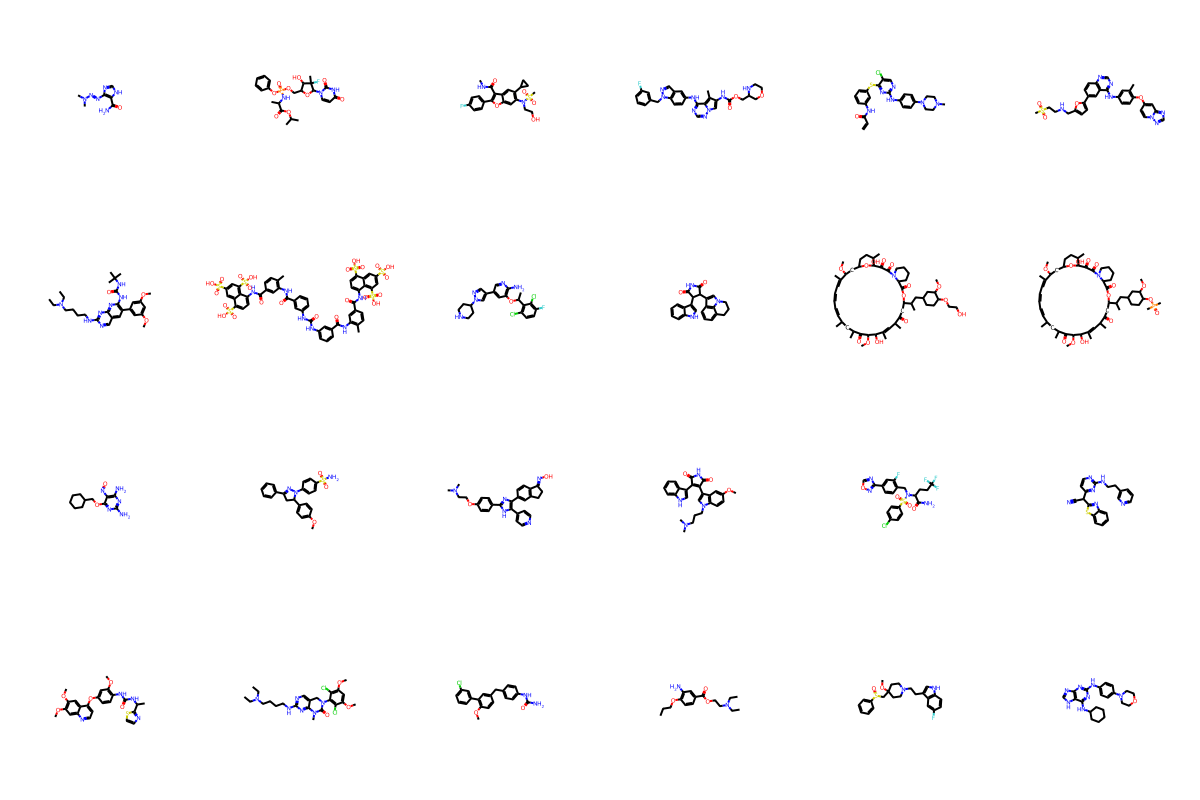

In [18]:
Draw.MolsToGridImage(uniq_mol.Mol.head(24), molsPerRow=6)

In [19]:
if (data_fname == 'data_v2' or data_fname == 'data_v4'): #baseline model
    print("generating xFlat for", data_fname)
    uniq_mol['xFlat'] = [torch.mean(torch.clone(data.x).type(torch.float32), dim=0) for data in uniq_mol['DataOGB']]

In [20]:
uniq_mol

,Drug,Mol,DataOGB
Drug_ID,,,
dacarbazine,CN(C)N=NC1=C(NC=N1)C(=O)N,<rdkit.Chem.rdchem.Mol object at 0x7f4c0cabfc30>,"[(edge_index, [tensor([ 0, 1, 1, 2, 1, 3,..."
CHEMBL3348974,CC(C)OC(=O)C(C)NP(=O)(OCC1C(C(C(O1)N2C=CC(=O)N...,<rdkit.Chem.rdchem.Mol object at 0x7f4c0cabf8b0>,"[(edge_index, [tensor([ 0, 1, 1, 2, 1, 3,..."
Nesbuvir,CNC(=O)C1=C(OC2=CC(=C(C=C21)C3CC3)N(CCO)S(=O)(...,<rdkit.Chem.rdchem.Mol object at 0x7f4c0cabf920>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
BMS-599626,CC1=C2C(=NC=NN2C=C1NC(=O)OCC3COCCN3)NC4=CC5=C(...,<rdkit.Chem.rdchem.Mol object at 0x7f4c0cabf990>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
WZ8040,CN1CCN(CC1)C2=CC=C(C=C2)NC3=NC=C(C(=N3)SC4=CC=...,<rdkit.Chem.rdchem.Mol object at 0x7f4c0cabfed0>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
...,...,...,...
SCHEMBL1557791,CC1=NN(C=C1NC2=NC=C(C(=C2)NC3=CC=CC=C3C(=O)NC)...,<rdkit.Chem.rdchem.Mol object at 0x7f4c0cb45690>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
homoharringtonine,CC(C)(CCCC(CC(=O)OC)(C(=O)OC1C2C3=CC4=C(C=C3CC...,<rdkit.Chem.rdchem.Mol object at 0x7f4c0cb45700>,"[(edge_index, [tensor([ 0, 1, 1, 2, 1, 3,..."
NSC169534,CC1C(C(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=C...,<rdkit.Chem.rdchem.Mol object at 0x7f4c0cb45770>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."


In [21]:
y = data.Y.copy()

In [22]:
y.value_counts()

Y
1    53253
0    35794
Name: count, dtype: int64

In [23]:
y.shape

(89047,)

In [24]:
ReaderWriter.dump_data(y.values, os.path.join(targetdata_dir_raw, 'y.pkl'))

In [25]:
df_rma_landm.shape

(908, 1021)

In [26]:
expression = np.array([df_rma_landm['DATA.'+ str(c)].values for c in data["Cosmic_ID"]])
expression.shape

(89047, 908)

In [27]:
df_rma_landm

,Unnamed: 0,GENE_SYMBOLS,GENE_title,DATA.906826,DATA.687983,DATA.910927,DATA.1240138,DATA.1240139,DATA.906792,DATA.910688,...,DATA.753584,DATA.907044,DATA.998184,DATA.908145,DATA.1659787,DATA.1298157,DATA.1480372,DATA.1298533,DATA.930299,DATA.905954.1
0,0,TSPAN6,tetraspanin 6 [Source:HGNC Symbol;Acc:11858],7.632023,7.548671,8.712338,7.797142,7.729268,7.074533,3.285198,...,7.105637,3.236503,3.038892,8.373223,6.932178,8.441628,8.422922,8.089255,3.112333,7.153127
1,3,SCYL3,SCY1-like 3 (S. cerevisiae) [Source:HGNC Symbo...,3.614794,4.066887,3.956230,4.063701,4.341500,4.270903,5.968168,...,3.696835,4.624013,4.348524,3.858121,3.947561,4.425849,3.550390,4.443337,4.266828,4.100493
2,19,BAD,BCL2-associated agonist of cell death [Source:...,7.458409,7.479327,7.419672,7.731137,6.998981,6.550210,6.354063,...,7.147962,6.478426,6.919537,6.801096,7.153122,7.234464,7.525257,6.066356,8.185968,4.967268
3,20,LAP3,leucine aminopeptidase 3 [Source:HGNC Symbol;A...,6.453926,6.742826,5.655691,5.259367,4.611395,6.930777,8.560707,...,5.383810,8.591164,6.208059,6.715130,6.530806,5.759933,7.810126,7.182077,5.663629,6.539451
4,28,SNX11,sorting nexin 11 [Source:HGNC Symbol;Acc:14975],4.767457,5.246301,4.645800,4.558836,5.456692,5.099542,7.574348,...,4.755084,6.761799,5.034195,4.958603,4.629068,4.982202,5.037259,4.611973,4.800284,4.967207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903,17083,PLEKHM1,"pleckstrin homology domain containing, family ...",6.167946,5.271099,5.784561,7.587263,6.479184,5.700915,6.617353,...,6.714959,6.368537,8.252268,6.436644,6.436742,5.551436,5.634834,7.083564,5.776658,6.306988
904,17400,MIF,macrophage migration inhibitory factor (glycos...,11.893872,11.841300,12.272137,12.000410,11.867211,12.621575,11.825283,...,12.286071,12.572595,12.254136,12.588238,12.366026,12.153612,12.265099,11.919307,12.762295,12.985613
905,17444,PRAF2,"PRA1 domain family, member 2 [Source:HGNC Symb...",5.060852,6.515567,4.815762,4.544863,6.071288,4.777850,3.455981,...,5.314914,2.943601,4.723601,5.769965,5.070665,3.443244,3.293080,2.978125,5.125786,4.404205
906,17575,LYN,v-yes-1 Yamaguchi sarcoma viral related oncoge...,5.892532,4.580184,6.482469,7.094195,7.932918,7.333405,10.455397,...,4.914232,9.453552,3.218797,4.073831,6.355383,8.348965,7.579339,4.456322,5.857488,3.013612


In [28]:
expression.shape

(89047, 908)

In [29]:
ReaderWriter.dump_data(expression, os.path.join(targetdata_dir_raw, 'expression.pkl'))

In [30]:
pairs = {i:(row.Drug1_ID, row.Drug2_ID) for i, row in data.iterrows()}
len(pairs)

89047

In [31]:
pairs

{0: ('dacarbazine', '717906-29-1'),
 1: ('CHEMBL3348974', '717906-29-1'),
 2: ('Nesbuvir', '717906-29-1'),
 3: ('BMS-599626', '717906-29-1'),
 4: ('WZ8040', '717906-29-1'),
 5: ('Arry-380', '717906-29-1'),
 6: ('219580-11-7', '717906-29-1'),
 7: ('suramin', '717906-29-1'),
 8: ('Crizotinib', '717906-29-1'),
 9: ('SCHEMBL224883', '717906-29-1'),
 10: ('CHEMBL3348822', '717906-29-1'),
 11: ('NCGC00346481-01', '717906-29-1'),
 12: ('NU6027', '717906-29-1'),
 13: ('ML141', '717906-29-1'),
 14: ('405554-55-4', '717906-29-1'),
 15: ('go 6983', '717906-29-1'),
 16: ('Avagacestat', '717906-29-1'),
 17: ('AS601245', '717906-29-1'),
 18: ('Ki20227', '717906-29-1'),
 19: ('SCHEMBL17378613', '717906-29-1'),
 20: ('1155877-97-6', '717906-29-1'),
 21: ('proparacaine', '717906-29-1'),
 22: ('CHEMBL166161', '717906-29-1'),
 23: ('Reversine', '717906-29-1'),
 24: ('1262770-73-9', '717906-29-1'),
 25: ('CHEMBL39740', '717906-29-1'),
 26: ('176977-56-3', '717906-29-1'),
 27: ('etodolac', '717906-29-1'),


In [32]:
ReaderWriter.dump_data(pairs, os.path.join(targetdata_dir_raw, 'pairs.pkl'))

In [33]:
ReaderWriter.dump_data(data, os.path.join(targetdata_dir_raw, 'data_pairs.pkl'))

In [34]:
data

,Drug1_ID,Drug2_ID,Cell_Line_ID,Cosmic_ID,Drug1,Drug2,Y
0,dacarbazine,717906-29-1,A-673,684052,CN(C)N=NC1=C(NC=N1)C(=O)N,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
1,CHEMBL3348974,717906-29-1,A-673,684052,CC(C)OC(=O)C(C)NP(=O)(OCC1C(C(C(O1)N2C=CC(=O)N...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,1
2,Nesbuvir,717906-29-1,A-673,684052,CNC(=O)C1=C(OC2=CC(=C(C=C21)C3CC3)N(CCO)S(=O)(...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
3,BMS-599626,717906-29-1,A-673,684052,CC1=C2C(=NC=NN2C=C1NC(=O)OCC3COCCN3)NC4=CC5=C(...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,1
4,WZ8040,717906-29-1,A-673,684052,CN1CCN(CC1)C2=CC=C(C=C2)NC3=NC=C(C(=N3)SC4=CC=...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,1
...,...,...,...,...,...,...,...
89042,Vorinostat,KU-60019,VM-CUB-1,909780,C1=CC=C(C=C1)NC(=O)CCCCCCC(=O)NO,CC1CN(CC(O1)C)CC(=O)NC2=CC3=C(C=C2)SC4=C(C=CC=...,1
89043,AZD5582,AZD4320,VM-CUB-1,909780,CC(C(=O)NC(C1CCCCC1)C(=O)N2CCCC2C(=O)NC3C(CC4=...,CN(CCC(CSC1=CC=CC=C1)NC2=C(C=C(C=C2)S(=O)(=O)N...,0
89044,957054-30-7,Sapitinib,VM-CUB-1,909780,CS(=O)(=O)N1CCN(CC1)CC2=CC3=C(S2)C(=NC(=N3)C4=...,CNC(=O)CN1CCC(CC1)OC2=C(C=C3C(=C2)C(=NC=N3)NC4...,1
89045,957054-30-7,Selumetinib,VM-CUB-1,909780,CS(=O)(=O)N1CCN(CC1)CC2=CC3=C(S2)C(=NC(=N3)C4=...,CN1C=NC2=C1C=C(C(=C2F)NC3=C(C=C(C=C3)Br)Cl)C(=...,1


In [35]:
%%time

if (data_fname == 'data_v1' or data_fname == 'data_v3'): #gnn model
    X = ReaderWriter.read_or_dump_data(file_name=norm_join_paths(targetdata_dir_raw, 'X.pkl'),
                              data_gen_fun=get_X_all_pairdata_synergy,
                              data_gen_params=(uniq_mol, pairs, "DataOGB"))
    print('we are running this')
    
if (data_fname == 'data_v2' or data_fname == 'data_v4'): #baseline model
    X = ReaderWriter.read_or_dump_data(file_name=norm_join_paths(targetdata_dir_raw, 'X_flat.pkl'),
                              data_gen_fun=get_X_all_pairdata_synergy_flat,
                              data_gen_params=(uniq_mol, pairs, "xFlat"))

we are running this
CPU times: user 14.2 s, sys: 54.1 ms, total: 14.3 s
Wall time: 14.6 s


In [36]:
len(X)

89047

In [37]:
%%time

# In order to generate a new Dataset, first remove the generated files above
dataset = MoleculeDataset(root=targetdata_dir, dataset='tdcSynergy')

Processing...
/home/ubuntu/mnt/graphnn/deepadr/dataset.py:106: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  data.expression = torch.tensor([expression[i]], dtype=torch.float32)
Done!


CPU times: user 16 s, sys: 1.43 s, total: 17.4 s
Wall time: 18 s


In [38]:
targetdata_dir

'/home/ubuntu/mnt/graphnn/data/processed/DrugComb_zip_thresh_1/data_v1'

In [39]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


Dataset: MoleculeDataset(89047):
Number of graphs: 89047
Number of features: 9
Number of classes: 2
